# Double ML - modeling

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import sklearn
import os
from matplotlib.pyplot import hist
from scipy import stats
import math

In [2]:
# set random seed for numpy
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

In [3]:
# read in the dataframe
df = pd.read_csv('df_mix.csv')

In [4]:
df

,country,t,onset2COWCS,decade,democracy,logmountain,ethnic_fractionalization,religion_fractionalization,language_fractionalization,leg_british,...,ecgrowth_demeaned,treat_agri,treat_mine,treat_fuel,treat_metal,iv_transport,iv_agri,iv_mine,iv_fuel,iv_metal
0,ABW,1991,0.0,7.0,NaN,NaN,NaN,0.004107,0.003889,NaN,...,NaN,0.0,1.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN
1,AFG,1991,NaN,7.0,0.0010,0.041836,0.007693,0.002717,0.006141,0.00,...,-0.013176,NaN,1.0,NaN,1.0,NaN,NaN,0.0,0.0,NaN
2,AGO,1991,NaN,7.0,0.0035,0.022721,0.007867,0.006276,0.007870,0.00,...,-0.029495,NaN,0.0,NaN,1.0,0.0,NaN,0.0,0.0,NaN
3,ALB,1991,0.0,7.0,0.0055,NaN,0.002204,0.004719,0.000399,0.00,...,-0.316090,0.0,1.0,1.0,1.0,NaN,NaN,0.0,0.0,NaN
4,AND,1991,0.0,7.0,NaN,NaN,0.007139,0.002326,0.006848,NaN,...,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3253,WSM,2008,NaN,8.0,NaN,NaN,0.001376,0.007871,0.000111,NaN,...,NaN,0.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN
3254,YEM,2008,NaN,8.0,0.0040,0.033032,NaN,0.000023,0.000080,NaN,...,-0.018882,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN
3255,ZAF,2008,NaN,8.0,0.0095,0.020412,0.007517,0.008603,0.008652,0.01,...,0.010913,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN
3256,ZMB,2008,NaN,8.0,0.0085,-0.016094,0.007808,0.007359,0.008734,0.01,...,0.034775,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN


In [5]:
df.columns

Index(['country', 't', 'onset2COWCS', 'decade', 'democracy', 'logmountain',
       'ethnic_fractionalization', 'religion_fractionalization',
       'language_fractionalization', 'leg_british', 'opec', 'logpop_M_diff',
       'logpopdens_diff', 'logoutreg_diff', 'ecgrowth_demeaned', 'treat_agri',
       'treat_mine', 'treat_fuel', 'treat_metal', 'iv_transport', 'iv_agri',
       'iv_mine', 'iv_fuel', 'iv_metal'],
      dtype='object')

In [6]:
outcome = ['onset2COWCS']
treatment = ['treat_agri']
instrument = ['iv_transport']
block = ['decade', 'democracy', 'logmountain',
       'ethnic_fractionalization', 'religion_fractionalization',
       'language_fractionalization', 'leg_british', 'opec', 'logpop_M_diff',
       'logpopdens_diff', 'logoutreg_diff', 'ecgrowth_demeaned']
df_1 = df[outcome+treatment+instrument+block]
df_1 = df_1.dropna()

In [7]:
df_1.columns

Index(['onset2COWCS', 'treat_agri', 'iv_transport', 'decade', 'democracy',
       'logmountain', 'ethnic_fractionalization', 'religion_fractionalization',
       'language_fractionalization', 'leg_british', 'opec', 'logpop_M_diff',
       'logpopdens_diff', 'logoutreg_diff', 'ecgrowth_demeaned'],
      dtype='object')

In [8]:
outcome = df_1['onset2COWCS'].reset_index(drop=True)

treatment = df_1['treat_agri'].reset_index(drop=True)

instrument = df_1['iv_transport'].reset_index(drop=True)

block = df_1[['decade', 'democracy', 'logmountain',
       'ethnic_fractionalization', 'religion_fractionalization',
       'language_fractionalization', 'leg_british', 'opec', 'logpop_M_diff',
       'logpopdens_diff', 'logoutreg_diff', 'ecgrowth_demeaned']].reset_index(drop=True)


## Specify Nuisance Function Models

The next step is to specify models for 

*   $\mu(z,x)=\mathbb{E}(Y|z,x)$
*   $m(z,x) = P(A=1|z,x)$
*   $p(x) = P(Z=1|x)$



In [9]:
from sklearn.neighbors import KNeighborsClassifier
# specify a model for mu(z,x)

# make a function that returns a sklearn model for later use in k-folding
def make_mu_model():
  return KNeighborsClassifier(n_neighbors=300)
mu_model = make_mu_model()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_zx = df_1[['iv_transport', 'decade', 'democracy', 'logmountain',
       'ethnic_fractionalization', 'religion_fractionalization',
       'language_fractionalization', 'leg_british', 'opec', 'logpop_M_diff',
       'logpopdens_diff', 'logoutreg_diff', 'ecgrowth_demeaned']].copy()

X_train, X_test, y_train, y_test = train_test_split(X_zx, outcome, test_size=0.2)
mu_model.fit(X_train, y_train)
y_pred = mu_model.predict_proba(X_test)[:,1]

test_ce=log_loss(y_test, y_pred)
print(f"Test Cross Entropy of fit model {test_ce}") 
baseline_ce=log_loss(y_test, y_train.mean()*np.ones_like(y_test))
print(f"Test Cross Entropy of no-covariate model {baseline_ce}")

Test Cross Entropy of fit model 0.06355940552063225
Test Cross Entropy of no-covariate model 0.06839842884402139


In [10]:
# specify a model for m(z,x)

def make_m_model():
  return LogisticRegression(max_iter=1000, warm_start=True, random_state=RANDOM_SEED)

m_model = make_m_model()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_train, X_test, a_train, a_test = train_test_split(X_zx, treatment, test_size=0.2)
m_model.fit(X_train, a_train)
a_pred = m_model.predict_proba(X_test)[:,1]

test_ce=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce}") 
baseline_ce=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce}")

Test CE of fit model 0.35093807563238283
Test CE of no-covariate model 0.6933473765320739


In [11]:
def make_p_model():
  return RandomForestClassifier(n_estimators=200, max_depth=5)

p_model = make_p_model()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_train, X_test, Z_train, Z_test = train_test_split(block, instrument, test_size=0.2)
p_model.fit(X_train, Z_train)
Z_pred = p_model.predict_proba(X_test)[:,1]

test_ce=log_loss(Z_test, Z_pred)
print(f"Test CE of fit model {test_ce}") 
baseline_ce=log_loss(Z_test, Z_train.mean()*np.ones_like(Z_test))
print(f"Test CE of no-covariate model {baseline_ce}")

Test CE of fit model 0.648357289154956
Test CE of no-covariate model 0.6893229819874541


## Use cross fitting to get predicted $\hat{\mu}$, $\hat{m}$, $\hat{p}$ for each unit

In [12]:
# helper functions to implement the cross fitting

def p_k_fold_fit_and_predict(make_model, X:pd.DataFrame, Z:np.array, n_splits:int):
    """
    Implements K fold cross-fitting for the model predicting the instrument Z. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    Z: array of instruments
    n_splits: number of splits to use
    """
    predictions = np.full_like(Z, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    for train_index, test_index in kf.split(X, Z):
      X_train = X.loc[train_index]
      Z_train = Z.loc[train_index]
      g = make_model()
      g.fit(X_train, Z_train)

      # get predictions for split
      predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]

    assert np.isnan(predictions).sum() == 0
    return predictions


def m_k_fold_fit_and_predict(make_model, X:pd.DataFrame, Z:np.array, A:np.array, n_splits:int):
    """
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    Z: array of instruments
    A: array of treatments
    n_splits: number of splits to use
    """
    predictions0 = np.full_like(A, np.nan, dtype=float)
    predictions1 = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_zx = X.copy()
    X_zx["Z"] = Z

    # for predicting A under Z=1 / Z=0 status for each data point 
    X0 = X_zx.copy()
    X0["Z"] = 0
    X1 = X_zx.copy()
    X1["Z"] = 1
    
    for train_index, test_index in kf.split(X_zx, A):
      X_train = X_zx.loc[train_index]
      A_train = A.loc[train_index]
      m = make_model()
      m.fit(X_train, A_train)
      predictions0[test_index] = m.predict_proba(X0.loc[test_index])[:,1]
      predictions1[test_index] = m.predict_proba(X1.loc[test_index])[:,1]

    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

def mu_k_fold_fit_and_predict(make_model, X:pd.DataFrame, Z:np.array, y:np.array, n_splits:int, output_type:str):
    """
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    Z: array of instruments
    y: array of outcomes
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"

    """
    predictions0 = np.full_like(y, np.nan, dtype=float)
    predictions1 = np.full_like(y, np.nan, dtype=float)
    if output_type == 'binary':
      kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
      kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_zx = X.copy()
    X_zx["Z"] = Z

    # for predicting effect under treatment / control status for each data point 
    X0 = X_zx.copy()
    X0["Z"] = 0
    X1 = X_zx.copy()
    X1["Z"] = 1

    
    for train_index, test_index in kf.split(X_zx, y):
      X_train = X_zx.loc[train_index]
      y_train = y.loc[train_index]
      mu = make_model()
      mu.fit(X_train, y_train)

      if output_type =='binary':
        predictions0[test_index] = mu.predict_proba(X0.loc[test_index])[:, 1]
        predictions1[test_index] = mu.predict_proba(X1.loc[test_index])[:, 1]
      elif output_type == 'continuous':
        predictions0[test_index] = mu.predict(X0.loc[test_index])
        predictions1[test_index] = mu.predict(X1.loc[test_index])

    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

In [13]:
p = p_k_fold_fit_and_predict(make_p_model, X=block, Z=instrument, n_splits=10)

In [15]:
m0,m1= m_k_fold_fit_and_predict(make_m_model, X=block, Z=instrument, A=treatment, n_splits=10)

(array([ 0.72604015, 21.05516436, 13.79476285, 36.30200751, 28.67858593,
        43.56240901, 51.18583059, 30.13066623, 38.11710788, 26.86348556]),
 array([0.74437842, 0.74782175, 0.75126509, 0.75470842, 0.75815176,
        0.76159509, 0.76503843, 0.76848177, 0.7719251 , 0.77536844,
        0.77881177]),
 <BarContainer object of 10 artists>)

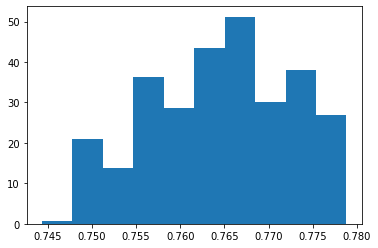

In [16]:
# check relevance
from matplotlib.pyplot import hist
hist(m1-m0, density=True)

In [17]:
mu0,mu1= mu_k_fold_fit_and_predict(make_mu_model, X=block, Z=instrument, y=outcome, n_splits=10, output_type="binary")

In [18]:
data_and_nuisance_estimates = pd.DataFrame({'p': p, 'mu0': mu0, 'mu1': mu1, 'm1': m1, 'm0': m0,
                                            'Z': instrument, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates.head()

,p,mu0,mu1,m1,m0,Z,A,Y
0,0.555499,0.016667,0.023333,0.900773,0.139800,1.0,1.0,0.0
1,0.298840,0.016667,0.026667,0.917114,0.146018,0.0,0.0,0.0
2,0.487749,0.026667,0.023333,0.917058,0.149759,1.0,1.0,0.0
3,0.553405,0.026667,0.030000,0.918063,0.151459,0.0,1.0,1.0
4,0.295512,0.016667,0.023333,0.911319,0.139594,0.0,0.0,0.0


## Combine predicted values and data into estimate of LATE

In [19]:
def late_estimator(mu1, mu0, m1, m0, p, Z, A, Y, prob = None):
  '''
  Estimator for LATE
  '''
  n = len(Y)
  phi_zy = mu1 - mu0 + Z*(Y-mu1)/p - (1-Z)*(Y-mu0)/(1-p)
  phi_za = m1 - m0 + Z*(A-m1)/p - (1-Z)*(A-m0)/(1-p)

  tau_za = phi_za.mean()
  tau_hat = phi_zy.mean()/tau_za
  phi = phi_zy - phi_za * tau_hat
  
  std_hat = math.sqrt((phi**2).mean()/tau_za**2/n)

  return tau_hat, std_hat


In [20]:
tau_hat, std_hat = late_estimator(**data_and_nuisance_estimates)
print(f"The estimate is {tau_hat} pm {1.96*std_hat}")

The estimate is 0.01709966470788354 pm 0.025072676106970112
